In [1]:
# from __future__ import division, print_function # for python < 3.3
import h5py
import sys
import os
import pickle
import numpy as np
import pandas as pd
import lavaburst # Hi-C segmentation tool, see https://github.com/nezar-compbio/lavaburst
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from itertools import islice

%matplotlib inline
sns.set_style('ticks')

/Users/Pushkareva/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Import data

In [31]:
hpy = h5py.File('BG3-1_20kb_IC.hdf5', 'r')
matrix = hpy['4 4'].value
pickle.loads(hpy['genomeIdxToLabel'].value)

{0: '4', 1: 'X', 2: 'M', 3: '3R', 4: '2R', 5: '3L', 6: '2L'}

In [32]:
matrix.shape

(1058, 1058)

In [33]:
# plt.figure(figsize = [20, 20])
# sns.heatmap(matrix[220:270, 220:270], annot = True, cmap='PuBu')

In [34]:
df = pd.DataFrame(matrix)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.loc[(df != 0).any(axis=1), :]
matrix = np.array(df)
np.fill_diagonal(matrix[1:, :], np.zeros(matrix.shape[0]-1))
np.fill_diagonal(matrix[:, 1:], np.zeros(matrix.shape[0]-1))

In [35]:
mtx = np.power(matrix, 4)

### Normalization by median

In [36]:
# import statistics

In [37]:
# mtx_medians = matrix.copy()
# for i, diag in enumerate(mtx_medians):
#     np.fill_diagonal(mtx_medians[i:],
#                      [statistics.mean(mtx_medians.diagonal(i))] * len(mtx_medians.diagonal(i)))
#     np.fill_diagonal(mtx_medians[:, i:],
#                      [statistics.mean(mtx_medians.diagonal(i))] * len(mtx_medians.diagonal(i)))

In [38]:
# normalized_mtx = matrix - mtx_medians # разница квадратов, или среднее

In [39]:
# mtx_norm = normalized_mtx

In [40]:
# mtx = np.power(mtx_norm, 3)

# Rubinov's Algorithm

### Галка

In [41]:
# res_left = []
# for j in range(len(mtx)):
#     left = 0
#     min_dist = min(j, len(mtx)-j)
#     if j < len(mtx)/2:
#         for i in range(j-min_dist,j):
#             left += mtx[i][j]
#         res_left.append(left)
#     else:
#         for i in range(j-min_dist+1,j):
#             left += mtx[i][j]
#         res_left.append(left)

In [42]:
# # j - строка
# res_right = []
# for j in range(len(mtx)):
#     right = 0
#     min_dist = min(j, len(mtx)-j)
#     if j < len(mtx)/2:
#         for i in range(j, j+min_dist+1):
#             right += mtx[j][i]
#         res_right.append(right)
#     else:
#         for i in range(j, j + min_dist):
#             right += mtx[j][i]
#         res_right.append(right)

### До конца

In [43]:
# A faster way to calculate sums over the columns/rows (axis=0/axis=1)of mtx
# np.triu(mtx) makes mtx upper triangular -- zeros under the main diagonal
# use it to eliminate double summation of elements
res_left = np.sum(np.triu(mtx), axis=0)
res_right = np.sum(np.triu(mtx), axis=1)

In [55]:
# # Example
# m = [[1,2], [0,5]]
# print(np.matrix(m))
# print(np.sum(m, axis=1))

matrix([[1, 2],
        [0, 5]])

In [44]:
# create list of pairs
res = list(zip(res_left, res_right))

In [46]:
# iterate over pairs and assign orientation -- right = 1, left = -1
binary_orientation = [] 
for pair in res:
    if pair[0] < pair[1]:
        binary_orientation.append(1)
    else:
        binary_orientation.append(-1)

# TADs

In [47]:
tads_all = []
tads_left_pos = []
tads_length = []
borders = []
newres = []

In [48]:
first_tads = [] # точки границ кластеров (i,i+1) 
first_tads_left_pos = []
first_tads_length = [] 
a = []
resupd = []
n = len(mtx)
tamm = np.zeros((n, n))
numbers = iter(range(len(binary_orientation)))
for i in numbers:
    if binary_orientation[i] == 1 and binary_orientation[i+1] == -1: 
        a.append([i, i + 2])
        tamm[i, i + 1] = 1   
        if res[i][0] + res[i+1][0] > res[i][1] + res[i+1][1]:
            first_tads.append(-1)
        elif res[i][0] + res[i+1][0] < res[i][1] + res[i+1][1]:
            first_tads.append(1)
        
        nres = [res[i][0] + res[i+1][0], res[i][1] + res[i+1][1]] ######
        resupd.append(nres) #######

        first_tads_left_pos.append(i) 
        first_tads_length.append(2)
        next(islice(numbers, 1, 1), None)
    else:

        first_tads.append(binary_orientation[i])
        first_tads_left_pos.append(i) 
        first_tads_length.append(1)
        resupd.append(res[i])  #########
        
newres.append(resupd)

tads_all.append(binary_orientation)
tads_all.append(first_tads)
borders.append(a)
tads_left_pos.append(first_tads_left_pos)
tads_length.append(first_tads_length)

In [49]:
max_level = 0
for level in range(1000):
    tads = [] # границы кластеров (i, i+1) 
    tads_left = [] 
    tads_len = [] 
    border = []
    resupd = []
    numbers = iter(range(len(tads_all[level+1]))) # or iter(range(len(tads_all[level+1])-1))? 
    print(level)
    if borders[level][0][0] == 0 and borders[level][0][1] == len(mtx):
        max_level = level
        print('Highest level', max_level)
        break
    for i in numbers:
        if tads_all[level+1][i] == 1 and tads_all[level+1][i+1] == -1:
            border.append([tads_left_pos[level][i], tads_left_pos[level][i] +\
                           tads_length[level][i] + tads_length[level][i+1]])
            tamm[tads_left_pos[level][i]][tads_left_pos[level][i] +\
                                          tads_length[level][i] + tads_length[level][i+1]-1] = level + 2
            if newres[level][i][0] + newres[level][i+1][0] > newres[level][i][1] + newres[level][i+1][1]:
                tads.append(-1)
            elif newres[level][i][0] + newres[level][i+1][0] < newres[level][i][1] + newres[level][i+1][1]:
                tads.append(1)
            nres = [newres[level][i][0] + newres[level][i+1][0], newres[level][i][1] + newres[level][i+1][1]]
            resupd.append(nres)
            
            tads_left.append(tads_left_pos[level][i]) 
            tads_len.append(tads_length[level][i] + tads_length[level][i+1]) 
            next(islice(numbers, 1, 1), None)
            
        else:
            tads.append(tads_all[level+1][i])
            tads_left.append(tads_left_pos[level][i]) 
            tads_len.append(tads_length[level][i])
            resupd.append(newres[level][i])
    
    newres.append(resupd)
    tads_all.append(tads)
    borders.append(border)
    tads_left_pos.append(tads_left)
    tads_length.append(tads_len)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Highest level 29


# Visualisation

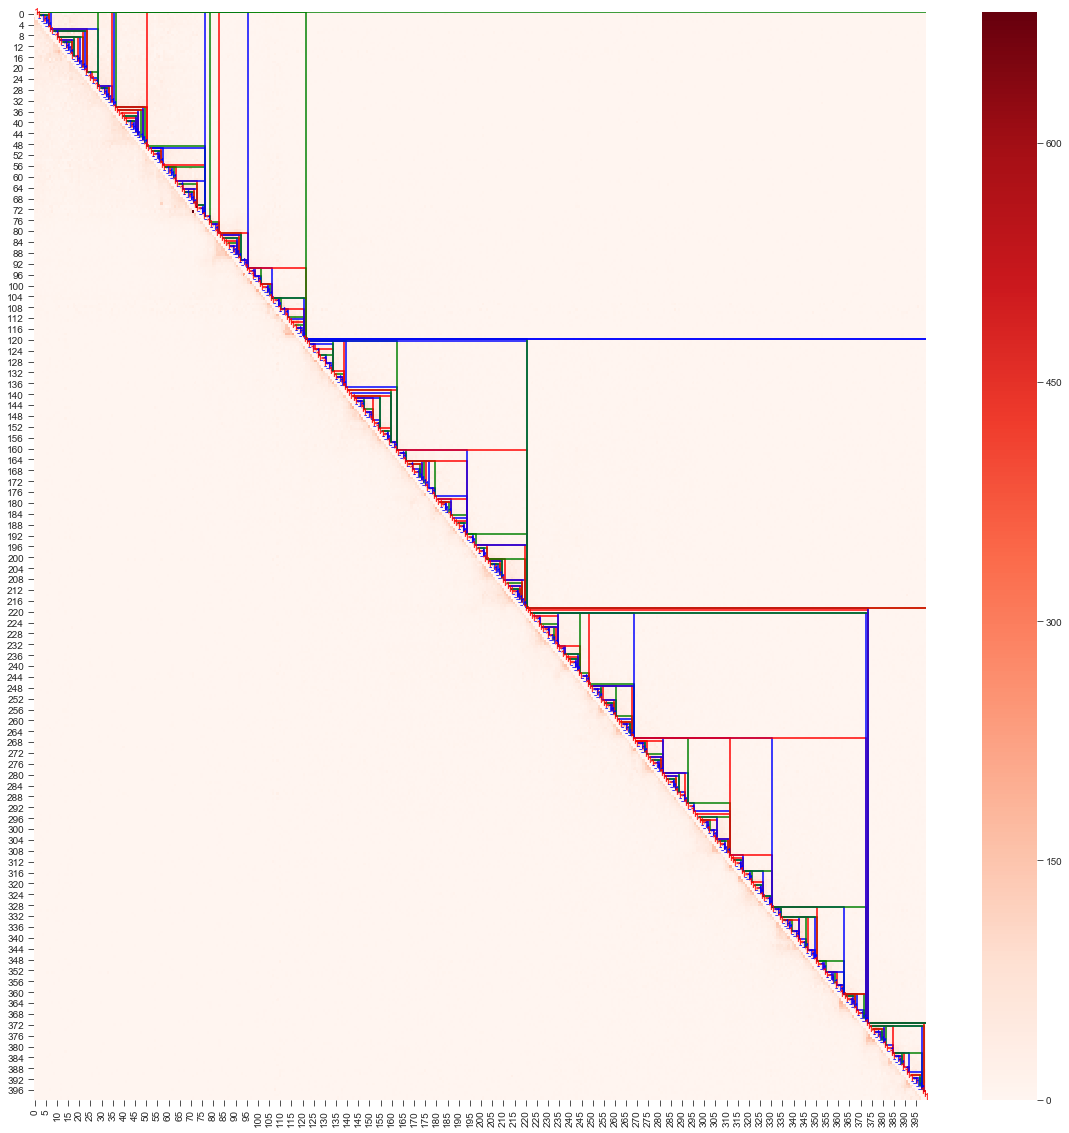

In [50]:
startmtx = 0 #901 #10
endmtx = 400 #300
def mtxplot(lvl, color):
    for j in range(len(lvl)):
        bgn = lvl[j][0] - startmtx
        end = lvl[j][1] - startmtx
        plt.plot([bgn +2, end+2], [bgn, bgn], color=color) # plt.plot(xs, ys, color)
        plt.plot([end+2, end+2], [bgn, end], color=color)
        
plt.figure(figsize=(20, 20))
sns.heatmap(matrix[:400, :400], cmap='Reds')

for i in range(startmtx, endmtx):
    val = binary_orientation[i]
    plt.text(i - startmtx, i + 0.8 - startmtx, val, {'color':'red' if val>0 else 'blue'})

if len(borders) % 3 == 0:
    colors = ['red', 'blue', 'green'] * int(len(borders) / 3)
else:
    colors = ['red', 'blue', 'green'] * int(len(borders) / 3)
    colors.append(['orange','blue','green'][: len(borders) % 3])

for lvl, color in zip(borders, colors):
    mtxplot(lvl, color)
# plt.savefig('mtx_crop_1degree.pdf', format='pdf')  # , dpi=1000)

# Some extra vizualizations

In [ ]:
def plot_heatmap_triu(m):
    fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(20,10), gridspec_kw={'height_ratios':[1,1]})
    #, sharex=True, gridspec_kw={'height_ratios':[3,1]})

    rotated = rotate(np.triu(np.nan_to_num(m)), angle=45)
    ax0.imshow(rotated[:(int(rotated.shape[0]/2)), :], cmap='PuBu', aspect='auto')
    ax0.set_ylim(70, 0)
    ax0.set_xlim([0, 50])
    ax0.spines['bottom'].set_visible(False)
    
    ax1.plot([i for i in range(len(y))], y)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlim([0, 40])
    
    plt.subplots_adjust(hspace=0)
    plt.show()

In [ ]:
plot_heatmap_triu(mtx)

In [ ]:
plt.figure(figsize=(20,10), frameon=False)
plt.plot([i for i in range(len(y))], y)

In [ ]:
from scipy.ndimage import rotate

In [ ]:
startmtx = 261 #901 #10
endmtx = 300 #300
def mtxplot(lvl, color):
    for j in range(len(lvl)):
        bgn = lvl[j][0] - startmtx
        end = lvl[j][1] - startmtx
        plt.plot([bgn+2, end+2], [bgn, bgn], color=color) # plt.plot(xs, ys, color)
        plt.plot([end+2, end+2], [bgn, end], color=color)
        
plt.figure(figsize=(20,20))
sns.heatmap(mtx[260:300, 260:300], cmap='PuBu')

for i in range(startmtx, endmtx):
    val = binary_orientation[i]
    plt.text(i - startmtx, i + 0.8 - startmtx, val, {'color':'red' if val>0 else 'blue'})

if len(borders) % 3 == 0:
    colors = ['red','blue','green'] * int(len(borders) / 3)
else:
    colors = ['red','blue','green'] * int(len(borders) / 3)
#     colors.append(['orange','blue','green'][: len(borders) % 3])

for lvl, color in zip(borders, colors):
    mtxplot(lvl, color)
# plt.title('Hierarchical tree for S2 cell line (700 to 800 bins slice), chr2L',fontsize='18')
plt.savefig('mtx_4degree.pdf', format='pdf', dpi=1000)

In [ ]:
# correlation between rubinov vector for trees and ctcf

# Class implementation and example

In [159]:
class RubinovAlgorithm:
    def __init__(self, hic_data, chr_number, n_iterations=1000):
        self.hic_file = hic_data
        self.chromosome_number = chr_number
        self.n_iterations = n_iterations
        # self.start = start
        # self.end = end
        self.get_hic_matrix()
        self.get_tad_orientation()
        self.get_first_level_tads()
        self.get_tads()


    def get_hic_matrix(self):
        print('Loading data...')
        hic_file = h5py.File(self.hic_file, 'r')
        chromosome = str(self.chromosome_number) + ' ' + str(self.chromosome_number)
        hic_matrix = hic_file[chromosome].value
        df = pd.DataFrame(hic_matrix)
        df = df.loc[:, (df != 0).any(axis=0)]
        df = df.loc[(df != 0).any(axis=1), :]
        hic_matrix = np.array(df)
        np.fill_diagonal(hic_matrix[1:, :], np.zeros(len(hic_matrix) - 1))
        np.fill_diagonal(hic_matrix[:, 1:], np.zeros(len(hic_matrix) - 1))
        self.hic_for_vizualization = hic_matrix
        self.hic_matrix = np.power(np.array(hic_matrix), 4)
        return self.hic_matrix

    def get_tad_orientation(self):
        left_summs = np.sum(np.triu(self.hic_matrix), axis=0)
        right_summs = np.sum(np.triu(self.hic_matrix), axis=1)
        self.pairs = list(zip(left_summs, right_summs))

        orientation = []
        for pair in self.pairs:
            if pair[0] < pair[1]:
                orientation.append(1)
            else:
                orientation.append(-1)
        self.orientation = orientation

    def get_first_level_tads(self):
        tads_all = []
        tads_left_pos = []
        tads_length = []
        borders = []
        new_pairs = []

        first_tads = []
        first_tads_left_pos = []
        first_tads_length = []
        brdr = []
        resupd = []
        numbers = iter(range(len(self.orientation)-1))
        for i in numbers:
            if self.orientation[i] == 1 and self.orientation[i + 1] == -1:
                brdr.append([i, i + 2])
                if self.pairs[i][0] + self.pairs[i + 1][0] > self.pairs[i][1] + self.pairs[i + 1][1]:
                    first_tads.append(-1)
                elif self.pairs[i][0] + self.pairs[i + 1][0] < self.pairs[i][1] + self.pairs[i + 1][1]:
                    first_tads.append(1)

                nres = [self.pairs[i][0] + self.pairs[i + 1][0], self.pairs[i][1] + self.pairs[i + 1][1]]
                resupd.append(nres)
                first_tads_left_pos.append(i)
                first_tads_length.append(2)
                next(islice(numbers, 1, 1), None)

            else:
                first_tads.append(self.orientation[i])
                first_tads_left_pos.append(i)
                first_tads_length.append(1)
                resupd.append(self.pairs[i])

        new_pairs.append(resupd)
        self.new_pairs = new_pairs

        tads_all.append(self.orientation)
        tads_all.append(first_tads)
        self.tads_all = tads_all

        borders.append(brdr)
        self.borders = borders

        tads_left_pos.append(first_tads_left_pos)
        self.tads_left_pos = tads_left_pos

        tads_length.append(first_tads_length)
        self.tads_length = tads_length

    def get_tads(self):
        print('Getting TADs...')
        for level in range(self.n_iterations):
            tads = []
            tads_left = []
            tads_len = []
            border = []
            updated_pairs = []
            numbers = iter(range(len(self.tads_all[level + 1])-1))

            if len(self.borders[level]) == 1 and self.borders[level][0][0] == 0 and\
                self.borders[level][0][1] == len(self.hic_matrix):
                max_level = level
                print('Highest level', max_level)
                break

            for i in numbers:
                if self.tads_all[level + 1][i] == 1 and self.tads_all[level + 1][i + 1] == -1:
                    border.append([self.tads_left_pos[level][i], self.tads_left_pos[level][i] +
                                   self.tads_length[level][i] + self.tads_length[level][i + 1]])

                    if self.new_pairs[level][i][0] + self.new_pairs[level][i + 1][0] > \
                            self.new_pairs[level][i][1] + self.new_pairs[level][i + 1][1]:
                        tads.append(-1)
                    elif self.new_pairs[level][i][0] + self.new_pairs[level][i + 1][0] < \
                            self.new_pairs[level][i][1] + self.new_pairs[level][i + 1][1]:
                        tads.append(1)

                    n_pairs = [self.new_pairs[level][i][0] + self.new_pairs[level][i + 1][0],
                            self.new_pairs[level][i][1] + self.new_pairs[level][i + 1][1]]

                    updated_pairs.append(n_pairs)
                    tads_left.append(self.tads_left_pos[level][i])
                    tads_len.append(self.tads_length[level][i] + self.tads_length[level][i + 1])
                    next(islice(numbers, 1, 1), None)

                else:
                    tads.append(self.tads_all[level + 1][i])
                    tads_left.append(self.tads_left_pos[level][i])
                    tads_len.append(self.tads_length[level][i])
                    updated_pairs.append(self.new_pairs[level][i])

            self.new_pairs.append(updated_pairs)
            self.tads_all.append(tads)
#             print(tads_all[-2], tads_all[-1])
            self.borders.append(border)
#             print(borders[-1])
            self.tads_left_pos.append(tads_left)
            self.tads_length.append(tads_len)
        print('Done')

    def mtxplot(self, letter, color):
        for j in range(len(letter)):
            bgn = letter[j][0] - self.startmtx
            end = letter[j][1] - self.startmtx
            plt.plot([bgn + 2, end + 2], [bgn, bgn], color=color)
            plt.plot([end + 2, end + 2], [bgn, end], color=color)

    def visualise_tree(self, start=None, end=None):
        print('Building hierarchical tree...')
        self.startmtx = start + 1
        self.endmtx = end
        plt.figure(figsize=(20, 20))
        sns.heatmap(self.hic_for_vizualization[start:end, start:end], cmap='Reds')
        for i in range(self.startmtx, self.endmtx):
            val = self.orientation[i]
            plt.text(i - self.startmtx, i + 0.8 - self.startmtx, val, {'color': 'red' if val > 0 else 'blue'})
        if len(self.borders) % 3 == 0:
            colors = ['red', 'blue', 'green'] * int(len(self.borders) / 3)
        else:
            colors = ['red', 'blue', 'green'] * int(len(self.borders) / 3)
            colors.append(['orange', 'blue', 'green'][: len(self.borders) % 3])
        for letter, color in zip(self.borders, colors):
            self.mtxplot(letter, color)
        plt.savefig(str(os.path.splitext(self.hic_file)[0]) + '_hierarhical_tree' + '.pdf', format='pdf')
        print('Done')

Loading data...
Getting TADs...
Done
Building hierarchical tree...
Done


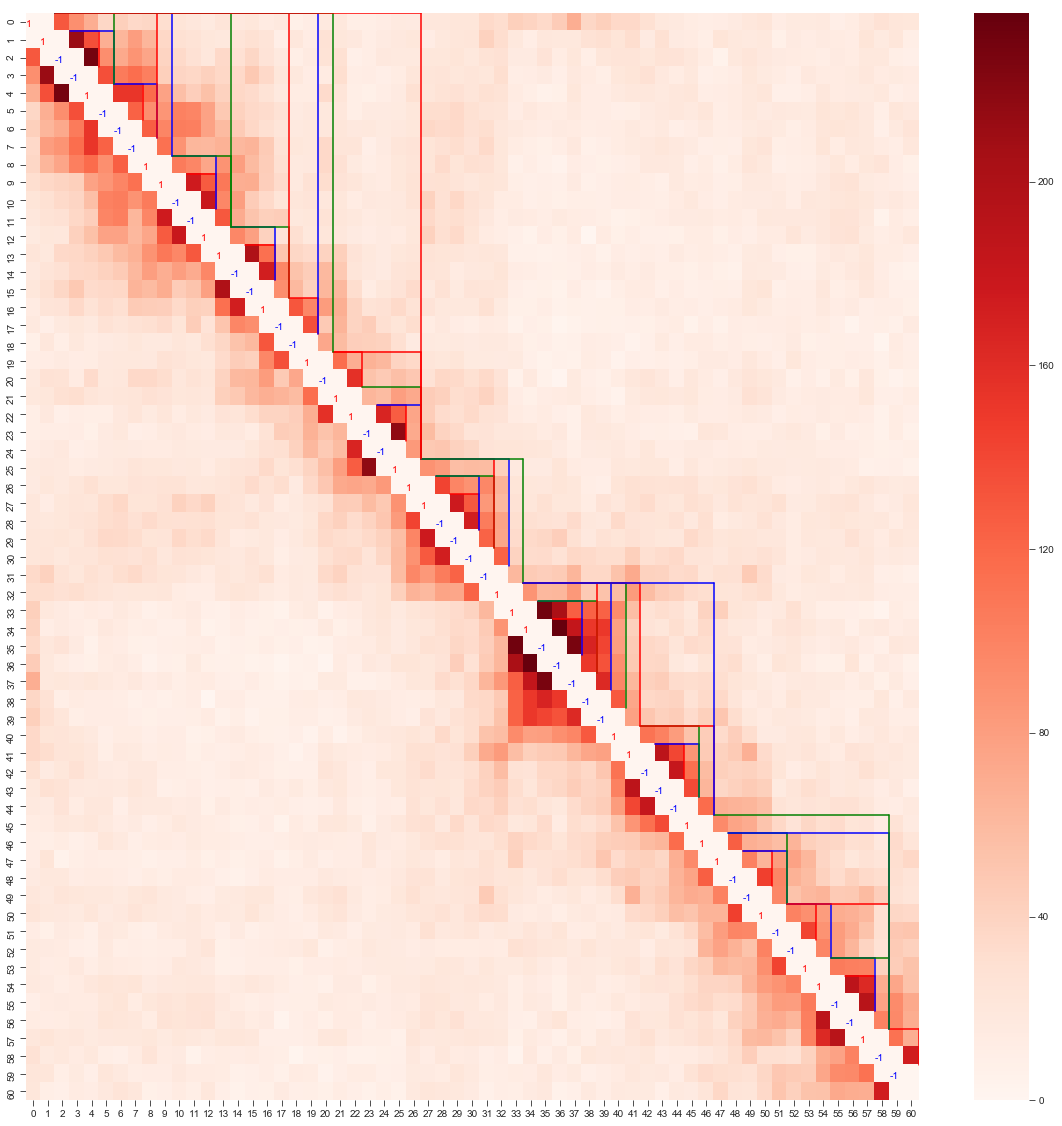

In [162]:
ra = RubinovAlgorithm('BG3-1_20kb_IC.hdf5', 0)
ra.visualise_tree(0, 61)

# Optimal TAD selection (TBD)

In [207]:
list_of_scores = []
for i, list_of_borders in enumerate(borders):
    for j, border in enumerate(list_of_borders):
        if border[0] == 0:
            print('if')
            list_of_scores.append(right_square/central_square)
        elif border[1] != len(mtx)-1:
            print('elif')
            print(border)
            left_square = mtx[border[0]-1][border[1]+2]
            central_square = mtx[border[0]][border[1]+2]
            right_square = mtx[border[0]+1][border[1]+2]
            list_of_scores.append(max(left_square/central_square, right_square/central_square))
        elif border[1] != len(mtx)-2:
            print('elif')
            print(border)
            left_square = mtx[border[0]-1][border[1]+2]
            central_square = mtx[border[0]][border[1]+2]
            right_square = mtx[border[0]+1][border[1]+2]
            list_of_scores.append(max(left_square/central_square, right_square/central_square))
        else:
            print('else')
            list_of_scores.append(left_square/central_square)
            

elif
[2, 4]
elif
[5, 7]
elif
[10, 12]
elif
[14, 16]
elif
[17, 19]
elif
[20, 22]
elif
[23, 25]
elif
[28, 30]
elif
[35, 37]
elif
[42, 44]
elif
[48, 50]
elif
[51, 53]
elif
[55, 57]
elif
[58, 60]


IndexError: index 62 is out of bounds for axis 0 with size 61